In [1]:
import json
import sys
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402
from src.utilities.model_config import RemoteModel  # noqa: E402

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


In [5]:
from langchain.tools import tool

#### Create Tools

In [6]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)
search_response = tavily_search.invoke({"query": "What is agentic RAG?"})
search_response

{'query': 'What is agentic RAG?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/artificial-intelligence/what-is-agentic-rag/',
   'title': 'What is Agentic RAG? - GeeksforGeeks',
   'content': 'Agentic RAG is an advanced version of Retrieval-Augmented Generation (RAG) where an AI agent retrieves external information and autonomously decides how to use that data. Single-Agent RAG uses a single intelligent agent that routes each user query to the most appropriate data source or tool. * By optimizing the data retrieval process, it improves the responsiveness and accuracy of agents within Agentic RAG systems which ensures that the system can retrieve the most relevant data and generate more accurate responses for complex tasks. Using the framework like LangGraph into Agentic RAG systems can increase their performance, adaptability and scalability which leads to the development of more intelligent, responsive and efficient 

In [7]:
import httpx
from markdownify import markdownify


async def afetch_raw_content(url: str) -> str | None:
    """
    Asynchronously fetch HTML content from a URL and convert it to markdown format.

    Parameters
    ----------
    url : str
        The URL to fetch content from.

    Returns
    -------
    str or None
        The fetched content converted to markdown if successful,
        None if any error occurs during fetching or conversion.

    Notes
    -----
    Uses a 10-second timeout to avoid hanging on slow sites or large pages.
    """
    try:
        # Create a client with reasonable timeout
        async with httpx.AsyncClient() as client:
            response = await client.get(url, timeout=10)
            response.raise_for_status()
            return markdownify(response.text)
    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None


# await afetch_raw_content(url)

In [8]:
from langchain_community.tools import DuckDuckGoSearchResults

In [9]:
search = DuckDuckGoSearchResults(output_format="list")

search.invoke("Obama's first name?")

[{'snippet': '1 day ago - Barack Hussein Obama II (born August 4, 1961) is an American politician who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, he was the first African American president. Obama previously served as a U.S. senator representing Illinois from ...',
  'title': 'Wikipedia Barack Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Barack_Obama'},
 {'snippet': '1 week ago - Barack Hussein Obama II (/bəˈrɑːk huːˈseɪn oʊˈbɑːmə/ ; born August 4, 1961) is an American politician and attorney. He was the 44th president of the United States from 2009 to 2017. He was the first African-American president in U.S. history. A member of the Democratic Party, he ...',
  'title': 'Simple English Wikipedia Barack Obama - Simple English Wikipedia, the free encyclopedia',
  'link': 'https://simple.wikipedia.org/wiki/Barack_Obama'},
 {'snippet': 'March 21, 2025 - Obama is a surname. It most commonly refers to Barack Obama (b

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper


async def duckduckgo_search(
    query: str, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    try:
        search = DuckDuckGoSearchResults(output_format="list")
        raw_results = await search.ainvoke(query)

        # format the data
        raw_results: list[dict[str, Any]] = [
            {
                "title": row["title"],
                "url": row["link"],
                "content": row["snippet"],
            }
            for row in raw_results
        ]

        if fetch_full_page:
            raw_results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in raw_results
            ]
        return {"results": raw_results}

    except Exception as e:
        print(f"Duckduckgo search failed: {str(e)}")
        return {"results": []}


async def google_search(
    query: str, max_results: int = 3, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    """
    Perform a web search using the GoogleSerperAPIWrapper.

    Parameters
    ----------
    query : str
        The search query string.
    max_results : int, optional
        Maximum number of results to return (default is 3).
    fetch_full_page : bool, optional
        If True, fetch and include the full page content for each result (default is False).

    Returns
    -------
    dict[str, list[dict[str, Any]]]
        Dictionary with a "results" key containing a list of result dictionaries.
        Each result dictionary contains:
            - "title": str, the result title
            - "url": str, the result URL
            - "content": str, the snippet or summary
            - "raw_content": str, the full page content if fetched, otherwise the snippet

    Notes
    -----
    Uses the GoogleSerperAPIWrapper for querying Google Serper. Handles errors gracefully.
    """
    search = GoogleSerperAPIWrapper(k=max_results)

    try:
        raw_results = await search.aresults(query)

        results = [
            {
                "title": res["title"],
                "url": res["link"],
                "content": res["snippet"],
                "raw_content": res["snippet"],
            }
            for res in raw_results["organic"]
        ]
        if fetch_full_page:
            results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in results
            ]
        return {"results": results}

    except Exception as e:
        print(f"Google search failed: {str(e)}")
        return {"results": []}

In [11]:
res = await duckduckgo_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=True
)

For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403


In [ ]:
res = await google_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=False
)

In [13]:
res

{'results': [{'title': 'Real Madrid 2-1 Barcelona (Oct 26, 2025) Game Analysis - ESPN',
   'url': 'https://www.espn.com/soccer/report/_/gameId/748236',
   'content': 'Real Madrid ended its four-game losing streak against rival Barcelona with a 2-1 victory in the first El Clásico of the season on Sunday.',
   'raw_content': 'Real Madrid ended its four-game losing streak against rival Barcelona with a 2-1 victory in the first El Clásico of the season on Sunday.'},
  {'title': 'How did Real Madrid DEFEAT Barcelona in El Clásico? - YouTube',
   'url': 'https://www.youtube.com/watch?v=g0acUd_aCf4',
   'content': "0:00 Real Madrid WINS El Clásico vs. Barcelona ; 1:08 Starting XI Sofascore ANALYSIS ; 3:11 Barcelona's highest xG allowed ; 4:05 Barcelona's ...",
   'raw_content': "0:00 Real Madrid WINS El Clásico vs. Barcelona ; 1:08 Starting XI Sofascore ANALYSIS ; 3:11 Barcelona's highest xG allowed ; 4:05 Barcelona's ..."},
  {'title': 'Real Madrid 2-1 Barcelona: El Clásico score stats and h

In [14]:
console.print(res["results"][2]["raw_content"][:1500])

Goals from Kylian Mbappe and Jude Bellingham gave Real Madrid a 2-1 win over Barcelona on Sunday, giving Xabi 
Alonso his first El Clasico win as ...

In [15]:
import calendar
from datetime import datetime


def day_name_tool(year: int, month: int, day: int) -> str:
    """Determine the name of the day for a given date.
    Parameters
    ----------
    year : int
        The year for which to generate the calendar (e.g., 2025).
    month : int
        The month for which to generate the calendar (1-12).
    day : int
        The day of the month (not used in calendar generation).

    Returns
    -------
    str
        The name of the day for the given date.
    """
    if not isinstance(year, int) or year < 1:
        raise ValueError("Year must be a positive integer.")
    if not isinstance(month, int):
        raise ValueError("Month must be an integer.")
    if not isinstance(day, int):
        raise ValueError("Day must be an integer.")
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not (1 <= day <= 31):
        raise ValueError("Day must be between 1 and 31.")

    return calendar.day_name[calendar.weekday(year, month, day)]


@tool(response_format="content_and_artifact")
async def search_tool(query: str, max_chars: int = 500) -> tuple[str, dict]:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=1000
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results, search_response


@tool(response_format="content")
def date_and_time_tool() -> str:
    """
    Get the current date, time, and day name as a string.

    Returns
    -------
    str
        The current date, time, and day name as a string.
    """
    raw_date: str = datetime.now().isoformat()
    date: str = raw_date.split("T")[0]
    time: str = raw_date.split("T")[-1]

    day_name: str = day_name_tool(
        year=int(date.split("-")[0]),
        month=int(date.split("-")[1]),
        day=int(date.split("-")[2]),
    )

    return f"Date: {date}\n\nTime: {time} (GMT+1)\n\nDay Name: {day_name}"

In [16]:
console.print(search_tool)

StructuredTool(
    name='search_tool',
    description='Perform a search using TavilySearch tool.\n\n    Parameters:\n    -----------\n    query: str\n   
The search query.\n    max_chars: int, default=1000\n        The maximum number of characters per source to return 
from the search results.\n\n    Returns:\n    --------\n    str\n        The formatted search results.',
    args_schema=<class 'langchain_core.utils.pydantic.search_tool'>,
    response_format='content_and_artifact',
    coroutine=<function search_tool at 0x129651b20>
)

In [ ]:
formatted_results, search_response = await search_tool.coroutine("what is agentic RAG?")
console.print(formatted_results)

In [ ]:
console.print(search_response)

In [ ]:
date_and_time_tool.func()

# console.print(date_tool)

In [17]:
chatbot_system_message = """
<SYSTEM>
    <ROLE>You are a knowledgeable and helpful chatbot assistant.</ROLE>

    <GUIDELINES>
    - Provide clear, accurate, and contextually relevant answers based on the user's input.
    - Use available tools to ensure responses are current and reliable.
    - Keep responses focused, concise, and directly related to the conversation.
    - If information is insufficient, politely ask for clarification.
    - Limit responses to a maximum of five sentences.
    </GUIDELINES>
</SYSTEM>
"""

query_prompt: str = """
<USER>
    <QUERY>{query}</QUERY>
</USER>
"""

summary_prompt: str = """
<USER>
    <GUIDELINES>
        - Expand the summary by incorporating the the above conversation while preserving context, key points, and
        user intent. 
        - Rework the summary if needed. Ensure that no critical information is lost and that the 
        conversation can continue naturally without gaps. 
        - Keep the summary concise yet informative, removing unnecessary repetition while maintaining clarity.
        - Only return the updated summary. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

    <SUMMARY>{summary}</SUMMARY>

</USER>
"""

no_summary_prompt: str = """
<USER>
    <GUIDELINES>
    - Summarize the conversation above while preserving full context, key points, and user intent. 
    - Your response should be concise yet detailed enough to ensure seamless continuation of the discussion.
    - Avoid redundancy, maintain clarity, and retain all necessary details for future exchanges.
    - Only return the summarized content. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

</USER>
"""

In [ ]:
# from typing import Annotated, TypedDict
# from uuid import uuid4

# from IPython.display import Image, Markdown, display
# from langchain.messages import RemoveMessage
# from langchain_core.messages import (
#     AIMessage,
#     AnyMessage,
#     HumanMessage,
#     SystemMessage,
#     ToolMessage,
# )
# from langchain_core.messages.utils import count_tokens_approximately
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import END, START, StateGraph
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy
# from langmem.short_term import RunningSummary, SummarizationNode
# from pydantic import BaseModel

In [45]:
from typing import Annotated, TypedDict

from langchain.messages import RemoveMessage
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langgraph.graph.message import add_messages

### Remove Messages

In [19]:
existing_msgs = [
    HumanMessage(content="Message 1", id=1),
    AIMessage(content="Message 2", id=2),
    HumanMessage(content="Message 3", id=3),
    AIMessage(
        content="Message 4",
        id=4,
    ),
    HumanMessage(content="Message 5", id=5),
]

new_messages = [
    AIMessage(
        content="Message 6",
        id=6,
    ),
    HumanMessage(content="Message 7", id=7),
    AIMessage(content="Message 8", id=8),
]

messages = add_messages(existing_msgs, new_messages)
messages

[HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='Message 3', additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content='Message 4', additional_kwargs={}, response_metadata={}, id='4'),
 HumanMessage(content='Message 5', additional_kwargs={}, response_metadata={}, id='5'),
 AIMessage(content='Message 6', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [20]:
# Remove messages except the last 2
messages_to_remove = [RemoveMessage(id=m.id) for m in messages[:-2]]
messages_to_remove

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='5'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='6')]

In [21]:
updated_messages = add_messages(messages, messages_to_remove)
updated_messages

[HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [22]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import RetryPolicy

In [ ]:
# ===============================================================
# =========================== STATES ============================
# ===============================================================
class MetaState(TypedDict):
    query: str
    answer: str

    messages: Annotated[list[AnyMessage], add_messages]


class State(MetaState):
    summary: str


# ===============================================================
# ============================ LLMS =============================
# ===============================================================
MAX_SUMMARY_TOKENS: int = 2048
MAX_MESSAGES: int = 10

llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.02,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)
summarization_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.QWEN3_30B_A3B,
).bind(max_tokens=MAX_SUMMARY_TOKENS)


# ===============================================================
# ============================ NODES ============================
# ===============================================================
async def call_llm(state: State) -> State:
    summary: str = state.get("summary", "")
    sys_msg = SystemMessage(content=chatbot_system_message)

    if summary:
        summary_msg = SystemMessage(content=f"Summary of conversation:\n\n {summary}")
        # Summary + most recent messages
        msgs_with_summary = [summary_msg] + state["messages"]

    else:
        msgs_with_summary = state["messages"]

    _msg = query_prompt.format(query=state.get("query", ""))
    query = HumanMessage(content=_msg)
    llm_with_tools = llm.bind_tools(tools=[search_tool, date_and_time_tool])
    response = await llm_with_tools.ainvoke([sys_msg] + msgs_with_summary + [query])

    return State(
        query=state.get("query", ""),
        answer=response.content,
        messages=[state.get("query", ""), response],
        summary=summary,
    )


async def summarization_node(state: State) -> State:
    summary: str = state.get("summary", "")

    if summary:
        summary_msg: list[AnyMessage] = [
            HumanMessage(content=summary_prompt.format(summary=summary))
        ]
    else:
        summary_msg = [HumanMessage(content=no_summary_prompt)]

    response: AIMessage = await summarization_llm.ainvoke(
        state["messages"] + summary_msg
    )

    # Delete ALL but the last 2 messages
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return State(
        query=state.get("query", None),
        answer=state.get("answer", None),
        messages=messages_to_remove,
        summary=response.content,
    )


# ===============================================================
# =========================== EDGEs =============================
# ===============================================================
def should_summarize(state: State) -> Literal["summarize", END]:
    if len(state["messages"]) > MAX_MESSAGES:
        return "summarize"

    return END

In [24]:
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy

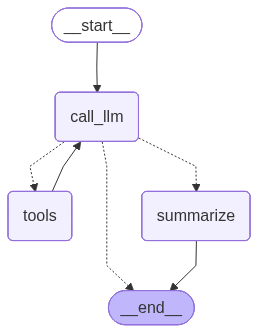

In [25]:
max_attempts: int = 2

# Memory
memory = MemorySaver()
tool_node = ToolNode([search_tool, date_and_time_tool])
builder = StateGraph(State)

# Add Nodes
builder.add_node(
    "call_llm",
    call_llm,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "tools",
    tool_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "summarize",
    summarization_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)

# Add Edges
# builder.add_conditional_edges(
#     START, should_summarize, {"summarize": "summarize", "call_llm": "call_llm"}
# )
builder.add_edge(START, "call_llm")
# builder.add_edge("call_llm", "summarize")
builder.add_conditional_edges("call_llm", tools_condition, {"tools": "tools", END: END})
builder.add_conditional_edges(
    "call_llm", should_summarize, {"summarize": "summarize", END: END}
)
builder.add_edge("tools", "call_llm")

# Build the graph
graph = builder.compile(checkpointer=memory)


# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [26]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"query": HumanMessage("Hello, I'm neidu. Tell me a joke")},
    config=config,  # type: ignore
)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

{'query': HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='a118a309-ed1f-4207-952a-eb4bd23f1bb8'),
 'answer': 'I am sorry, I cannot fulfill this request. The search results do not provide a joke, but instead point to apps and videos.\n',
 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='a118a309-ed1f-4207-952a-eb4bd23f1bb8'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761694837-XDzSh8YbeUgkvbqPV9mN', 

In [29]:
# msg: str = "Who was the first Nigerian Catholic priest in Nigeria?"
msg: str = "What's today's date? and What day is tomorrow?"
# msg: str = "What is my name?"
# msg: str = "What is langgraph? Which is better between langgraph and AutoGen?"
response = await graph.ainvoke({"query": HumanMessage(msg)}, config=config)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

{'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='844ceea9-f82b-4aed-9b14-8d72df829db6'),
 'answer': 'Today is Wednesday, October 29, 2025. Tomorrow is Thursday, October 30, 2025.\n',
 'messages': [ToolMessage(content='Title: The Centenary Priestly Ordination Anniversary Of The First Nigerian ...\nContent: Today, exactly 100 years ago, on the Feast of Epiphany (which we celebrated yesterday), on 6 January, 1920, our much-loved brother and audacious father, Fr. Paul Emechete, was raised to the dignity of the eternal priesthood of Christ Jesus, in the solemn order of the ancient priest, Melchizedek. It was the Society of African Missions (SMA Fathers) who gave West Africa its own first Catholic priest in modern times when Bishop Thomas Broderick, SMA, Vicar Apostolic of Western Nigeria, ordained Rev [truncated]\nURL: https://warridiocese.org/celebrating-a-symbol-of-epiphany-the-centenary-priestly-ordination-an

In [30]:
len(response["messages"])

6

In [31]:
# get the latest state snapshot
print(graph.get_state(config))

StateSnapshot(values={'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='844ceea9-f82b-4aed-9b14-8d72df829db6'), 'answer': 'Today is Wednesday, October 29, 2025. Tomorrow is Thursday, October 30, 2025.\n', 'messages': [ToolMessage(content='Title: The Centenary Priestly Ordination Anniversary Of The First Nigerian ...\nContent: Today, exactly 100 years ago, on the Feast of Epiphany (which we celebrated yesterday), on 6 January, 1920, our much-loved brother and audacious father, Fr. Paul Emechete, was raised to the dignity of the eternal priesthood of Christ Jesus, in the solemn order of the ancient priest, Melchizedek. It was the Society of African Missions (SMA Fathers) who gave West Africa its own first Catholic priest in modern times when Bishop Thomas Broderick, SMA, Vicar Apostolic of Western Nigeria, ordained Rev [truncated]\nURL: https://warridiocese.org/celebrating-a-symbol-of-epiphany-the-centenary-pri

In [32]:
# State history
list(graph.get_state_history(config))

[StateSnapshot(values={'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='844ceea9-f82b-4aed-9b14-8d72df829db6'), 'answer': 'Today is Wednesday, October 29, 2025. Tomorrow is Thursday, October 30, 2025.\n', 'messages': [ToolMessage(content='Title: The Centenary Priestly Ordination Anniversary Of The First Nigerian ...\nContent: Today, exactly 100 years ago, on the Feast of Epiphany (which we celebrated yesterday), on 6 January, 1920, our much-loved brother and audacious father, Fr. Paul Emechete, was raised to the dignity of the eternal priesthood of Christ Jesus, in the solemn order of the ancient priest, Melchizedek. It was the Society of African Missions (SMA Fathers) who gave West Africa its own first Catholic priest in modern times when Bishop Thomas Broderick, SMA, Vicar Apostolic of Western Nigeria, ordained Rev [truncated]\nURL: https://warridiocese.org/celebrating-a-symbol-of-epiphany-the-centenary-pr

### Streaming

In [39]:
MAX_MESSAGES: int = 10

In [40]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-02"}}
response = graph.astream(
    {"query": HumanMessage("Hello, I'm neidu")},
    config=config,  # type: ignore
    stream_mode="values",
)

async for chunk in response:
    print(chunk)

{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}), 'messages': []}
{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='95082f02-a96e-4862-bd83-389d567c4adb'), 'answer': 'Hello neidu, how can I help you today?\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='95082f02-a96e-4862-bd83-389d567c4adb'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-17

In [41]:
response = graph.astream(
    {"query": HumanMessage("What's my name?")},
    config=config,  # type: ignore
    stream_mode="messages",
)

async for chunk in response:
    print(chunk)

(AIMessageChunk(content='Your', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--d152cdb2-b5be-4a07-bb0c-1d9744dcacfa'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'call_llm', 'langgraph_triggers': ('branch:to:call_llm',), 'langgraph_path': ('__pregel_pull', 'call_llm'), 'langgraph_checkpoint_ns': 'call_llm:3690dab3-1727-161c-0e0d-2aecf4f5843d', 'checkpoint_ns': 'call_llm:3690dab3-1727-161c-0e0d-2aecf4f5843d', 'ls_provider': 'openai', 'ls_model_name': 'google/gemini-2.0-flash-001', 'ls_model_type': 'chat', 'ls_temperature': 0.02})
(AIMessageChunk(content=' name is neidu.\n', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'google/gemini-2.0-flash-001', 'model_provider': 'openai'}, id='lc_run--d152cdb2-b5be-4a07-bb0c-1d9744dcacfa', chunk_position='last'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'call_llm', 'langgraph_triggers': ('branch:to:call_llm',), 'langgraph_path': ('__preg

<br>

### Real-time Response Streaming (astream_events)

- Use `astream_events` to get real-time events as they occur in the graph execution.
- Useful for creating dynamic UIs or dashboards that update in real-time.

In [42]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("What is tomorrow's date?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is tomorrow's date?", additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '12f5612c-5672-42d5-8f1c-c551a2c7ddc4', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is tomorrow's date?", additional_kwargs={}, response_metadata={}), 'answer': 'Your name is neidu.\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='95082f02-a96e-4862-bd83-389d567c4adb'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_token

In [48]:
res = {
    "event": "on_chat_model_end",
    "data": {
        "output": AIMessage(
            content="Tomorrow's date is 2025-10-30.",
            additional_kwargs={},
            response_metadata={
                "finish_reason": "stop",
                "model_name": "google/gemini-2.0-flash-001",
                "model_provider": "openai",
            },
            id="lc_run--5ef55d3c-c971-4339-ba70-0cea75020260",
            usage_metadata={
                "input_tokens": 424,
                "output_tokens": 17,
                "total_tokens": 441,
                "input_token_details": {"cache_read": 0},
                "output_token_details": {"reasoning": 0},
            },
        ),
        "input": {
            "messages": [
                [
                    SystemMessage(
                        content="\n<SYSTEM>\n    <ROLE>You are a knowledgeable and helpful chatbot assistant.</ROLE>\n\n    <GUIDELINES>\n    - Provide clear, accurate, and contextually relevant answers based on the user's input.\n    - Use available tools to ensure responses are current and reliable.\n    - Keep responses focused, concise, and directly related to the conversation.\n    - If information is insufficient, politely ask for clarification.\n    - Limit responses to a maximum of five sentences.\n    </GUIDELINES>\n</SYSTEM>\n",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    HumanMessage(
                        content="Hello, I'm neidu",
                        additional_kwargs={},
                        response_metadata={},
                        id="95082f02-a96e-4862-bd83-389d567c4adb",
                    ),
                    AIMessage(
                        content="Hello neidu, how can I help you today?\n",
                        additional_kwargs={"refusal": None},
                        response_metadata={
                            "token_usage": {
                                "completion_tokens": 12,
                                "prompt_tokens": 276,
                                "total_tokens": 288,
                                "completion_tokens_details": {
                                    "accepted_prediction_tokens": None,
                                    "audio_tokens": None,
                                    "reasoning_tokens": 0,
                                    "rejected_prediction_tokens": None,
                                    "image_tokens": 0,
                                },
                                "prompt_tokens_details": {
                                    "audio_tokens": None,
                                    "cached_tokens": 0,
                                },
                            },
                            "model_provider": "openai",
                            "model_name": "google/gemini-2.0-flash-001",
                            "system_fingerprint": None,
                            "id": "gen-1761695551-oviRwFGdfMgcZzJRinMh",
                            "finish_reason": "stop",
                            "logprobs": None,
                        },
                        id="lc_run--bcf5c1f8-9098-4c34-b85a-b55befffcc65-0",
                        usage_metadata={
                            "input_tokens": 276,
                            "output_tokens": 12,
                            "total_tokens": 288,
                            "input_token_details": {"cache_read": 0},
                            "output_token_details": {"reasoning": 0},
                        },
                    ),
                    HumanMessage(
                        content="What's my name?",
                        additional_kwargs={},
                        response_metadata={},
                        id="e00efcfd-f9c4-4e81-b326-6a4c23bc6206",
                    ),
                    AIMessage(
                        content="Your name is neidu.\n",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "google/gemini-2.0-flash-001",
                            "model_provider": "openai",
                        },
                        id="lc_run--d152cdb2-b5be-4a07-bb0c-1d9744dcacfa",
                        usage_metadata={
                            "input_tokens": 292,
                            "output_tokens": 7,
                            "total_tokens": 299,
                            "input_token_details": {"cache_read": 0},
                            "output_token_details": {"reasoning": 0},
                        },
                    ),
                    HumanMessage(
                        content="What is tomorrow's date?",
                        additional_kwargs={},
                        response_metadata={},
                        id="bb46232f-9e5d-429c-81cd-f6e407f63ae6",
                    ),
                    AIMessage(
                        content="",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "tool_calls",
                            "model_name": "google/gemini-2.0-flash-001",
                            "model_provider": "openai",
                        },
                        id="lc_run--feb9af65-adae-4550-8e3d-31f109a6054d",
                        tool_calls=[
                            {
                                "name": "date_and_time_tool",
                                "args": {},
                                "id": "tool_0_date_and_time_tool_twdF1mVpoQ53QKi0klbC",
                                "type": "tool_call",
                            }
                        ],
                        usage_metadata={
                            "input_tokens": 305,
                            "output_tokens": 7,
                            "total_tokens": 312,
                            "input_token_details": {"cache_read": 0},
                            "output_token_details": {"reasoning": 0},
                        },
                    ),
                    ToolMessage(
                        content="Date: 2025-10-29\n\nTime: 00:52:35.111227 (GMT+1)\n\nDay Name: Wednesday",
                        name="date_and_time_tool",
                        id="402c72eb-799c-48db-8c65-dada0e62c8c1",
                        tool_call_id="tool_0_date_and_time_tool_twdF1mVpoQ53QKi0klbC",
                    ),
                    HumanMessage(
                        content="\n<USER>\n    <QUERY>content=\"What is tomorrow's date?\" additional_kwargs={} response_metadata={} id='bb46232f-9e5d-429c-81cd-f6e407f63ae6'</QUERY>\n</USER>\n",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                ]
            ]
        },
    },
    "run_id": "5ef55d3c-c971-4339-ba70-0cea75020260",
    "name": "ChatOpenAI",
    "tags": ["seq:step:1"],
    "metadata": {
        "thread_id": "test-02",
        "langgraph_step": 9,
        "langgraph_node": "call_llm",
        "langgraph_triggers": ("branch:to:call_llm",),
        "langgraph_path": ("__pregel_pull", "call_llm"),
        "langgraph_checkpoint_ns": "call_llm:ecba4c21-3c9b-edaf-ed07-2a164203f0d9",
        "checkpoint_ns": "call_llm:ecba4c21-3c9b-edaf-ed07-2a164203f0d9",
        "ls_provider": "openai",
        "ls_model_name": "google/gemini-2.0-flash-001",
        "ls_model_type": "chat",
        "ls_temperature": 0.02,
        "revision_id": "d7e837a-dirty",
    },
    "parent_ids": [
        "12f5612c-5672-42d5-8f1c-c551a2c7ddc4",
        "ad89199d-7aa6-4273-a78a-fe295f6bb155",
    ],
}


res.get("metadata", {})

{'thread_id': 'test-02',
 'langgraph_step': 9,
 'langgraph_node': 'call_llm',
 'langgraph_triggers': ('branch:to:call_llm',),
 'langgraph_path': ('__pregel_pull', 'call_llm'),
 'langgraph_checkpoint_ns': 'call_llm:ecba4c21-3c9b-edaf-ed07-2a164203f0d9',
 'checkpoint_ns': 'call_llm:ecba4c21-3c9b-edaf-ed07-2a164203f0d9',
 'ls_provider': 'openai',
 'ls_model_name': 'google/gemini-2.0-flash-001',
 'ls_model_type': 'chat',
 'ls_temperature': 0.02,
 'revision_id': 'd7e837a-dirty'}

In [ ]:
# Generate real-time events
response = graph.astream_events(
    {"query": HumanMessage("Please verify that for me.")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    if chunk.get("event") == "on_chat_model_end":
        print(chunk.get("data").get("output").content)

In [51]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("Why is the earth round?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content='Why is the earth round?', additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1a88b278-029c-4b01-bcba-2a0dd44ac55f', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content='Why is the earth round?', additional_kwargs={}, response_metadata={}), 'answer': '```tool_outputs\n{"tool_0_search_tool_1X1Poac5Ii4e8p148qpG_response": {"result": "Title: Why is the Earth round? - Space Place - NASA Science for Kids\\nContent: The force of gravity pulls all the mass of Earth toward Earth\'s center. Gravity pulls equally from all sides. This makes Earth a sphere, which is a three-dimensional circle. ... Over billions of years, Earth became a sphere because of gravity. Gravity pulls equally from all sides. This makes Earth a sphere. A sphere is a three-dimensional circle.\\nURL: https://spaceplace.nasa.gov/ear

In [ ]:
{
    "event": "on_chat_model_end",
    "data": {
        "output": AIMessage(
            content="",
            additional_kwargs={},
            response_metadata={
                "finish_reason": "tool_calls",
                "model_name": "openai/gpt-oss-20b",
                "model_provider": "openai",
            },
            id="lc_run--00f6ab86-4e41-49f9-b407-b7f868de6366",
            tool_calls=[
                {
                    "name": "search_tool",
                    "args": {
                        "query": "Peter Obi education where did he study",
                        "max_chars": 500,
                    },
                    "id": "functions.search_tool_134c",
                    "type": "tool_call",
                }
            ],
            usage_metadata={
                "input_tokens": 334,
                "output_tokens": 56,
                "total_tokens": 390,
                "input_token_details": {},
                "output_token_details": {},
            },
        ),
        "input": {
            "messages": [
                [
                    HumanMessage(
                        content="Hello, I'm neidu",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Hello Neidu! 👋 How can I help you today?",
                        additional_kwargs={"refusal": None},
                        response_metadata={
                            "token_usage": {
                                "completion_tokens": 50,
                                "prompt_tokens": 192,
                                "total_tokens": 242,
                                "completion_tokens_details": None,
                                "prompt_tokens_details": None,
                            },
                            "model_provider": "openai",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": None,
                            "id": "gen-1761438180-BZ1Pe6JAyGcYGUc0s09C",
                            "finish_reason": "stop",
                            "logprobs": None,
                        },
                        id="lc_run--bdd6d5c6-f7fe-49d9-b9ef-8212b73be0be-0",
                        usage_metadata={
                            "input_tokens": 192,
                            "output_tokens": 50,
                            "total_tokens": 242,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="What's my name?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="You’re Neidu!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--c1bdfa40-81d9-4e1e-9ae9-ff3f2877d00e",
                        usage_metadata={
                            "input_tokens": 219,
                            "output_tokens": 42,
                            "total_tokens": 261,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Are you sure?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Yes—I’m remembering that you introduced yourself as “Neidu.” If that’s not correct or you’d like me to use a different name, just let me know!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": "fp_e189667b30",
                            "model_provider": "openai",
                        },
                        id="lc_run--306354b6-872b-4560-a146-6e6567c35a35",
                        usage_metadata={
                            "input_tokens": 249,
                            "output_tokens": 87,
                            "total_tokens": 336,
                            "input_token_details": {},
                            "output_token_details": {"reasoning": 44},
                        },
                    ),
                    HumanMessage(
                        content="Please verify that for me.",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="I’m remembering that you introduced yourself as “Neidu.”  \nWould you like me to confirm that’s the name you’d like me to use?",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--97e572b5-91f4-42bb-af87-1139e8ce22b4",
                        usage_metadata={
                            "input_tokens": 288,
                            "output_tokens": 146,
                            "total_tokens": 434,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Where did Peter Obi study?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                ]
            ]
        },
    },
    "run_id": "00f6ab86-4e41-49f9-b407-b7f868de6366",
    "name": "ChatOpenAI",
    "tags": ["seq:step:1"],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 13,
        "langgraph_node": "llm_call",
        "langgraph_triggers": ("branch:to:llm_call",),
        "langgraph_path": ("__pregel_pull", "llm_call"),
        "langgraph_checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "ls_provider": "openai",
        "ls_model_name": "openai/gpt-oss-20b",
        "ls_model_type": "chat",
        "ls_temperature": 0.0,
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "307e02fc-6562-4d85-822f-9d6ed1966ec1",
    ],
}

In [ ]:
# {
#     "event": "on_chat_model_stream",
#     "data": {
#         "chunk": AIMessageChunk(
#             content="",
#             additional_kwargs={},
#             response_metadata={},
#             id="lc_run--28fad7d7-2325-4173-8b33-07126aa56f4d",
#             chunk_position="last",
#         )
#     },
#     "run_id": "28fad7d7-2325-4173-8b33-07126aa56f4d",
#     "name": "ChatOpenAI",
#     "tags": ["seq:step:1"],
#     "metadata": {
#         "thread_id": "test-02",
#         "langgraph_step": 21,
#         "langgraph_node": "call_llm",
#         "langgraph_triggers": ("branch:to:call_llm",),
#         "langgraph_path": ("__pregel_pull", "call_llm"),
#         "langgraph_checkpoint_ns": "call_llm:e08f0c17-22d3-1d66-e9a1-7fd331c10cc1",
#         "checkpoint_ns": "call_llm:e08f0c17-22d3-1d66-e9a1-7fd331c10cc1",
#         "ls_provider": "openai",
#         "ls_model_name": "google/gemini-2.0-flash-001",
#         "ls_model_type": "chat",
#         "ls_temperature": 0.02,
#     },
#     "parent_ids": [
#         "1a88b278-029c-4b01-bcba-2a0dd44ac55f",
#         "0f28c09c-0c96-438a-8ee2-6d1037819dfe",
#     ],
# }

In [ ]:
{
    "event": "on_tool_end",
    "data": {
        "output": {
            "query": "Peter Obi education where did he study",
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": [
                {
                    "url": "https://simple.wikipedia.org/wiki/Peter_Obi",
                    "title": "Peter Obi - Simple English Wikipedia, the free encyclopedia",
                    "content": "He had his tertiary education at the University of Nigeria in 1984 after his secondary education at Christ the King College, Onitsha.",
                    "score": 0.8827621,
                    "raw_content": None,
                },
                {
                    "url": "https://kids.kiddle.co/Peter_Obi",
                    "title": "Peter Obi for Kids",
                    "content": "In 1980, he started studying Philosophy at the University of Nigeria in Nsukka. He graduated in 1984. Peter Obi also studied at several other",
                    "score": 0.86108357,
                    "raw_content": None,
                },
                {
                    "url": "https://www.legit.ng/politics/1670240-peter-obis-educational-background-confirmed-details-show-schooled/",
                    "title": "Peter Obi's Educational Background: Details Show His Certifications",
                    "content": "He attended Lagos Business School, where he completed the Chief Executive Program, and later enrolled at Harvard Business School, completing two",
                    "score": 0.8138313,
                    "raw_content": None,
                },
            ],
            "response_time": 0.89,
            "request_id": "857f10aa-8815-4789-b120-c59ead398ceb",
        },
        "input": {"query": "Peter Obi education where did he study"},
    },
    "run_id": "e47fd9bf-2d37-4f5c-9369-ed62f47ba233",
    "name": "tavily_search",
    "tags": [],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 14,
        "langgraph_node": "tools",
        "langgraph_triggers": ("branch:to:tools",),
        "langgraph_path": ("__pregel_pull", "tools"),
        "langgraph_checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "212d580a-f36b-4d65-9489-209cb2ef0c2c",
        "86bb7b58-1172-4af4-b8b1-e9f1af3b9251",
    ],
}